In [1]:
from glob import glob
import pandas as pd
import numpy as np
from scipy import stats
from os import makedirs
from multiprocessing import cpu_count
from subprocess import run
from re import sub
from nb02_subtraction import dual_thresholding
from nilearn import plotting, reporting

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-d4pkdxiu because the default path (/u/aenge/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# If necessary, unzip the SDM software
if not glob("../software/*/sdm"):

    import tarfile

    sdm_tar_path = glob("../software/Sdm*.tar.gz")[0]
    sdm_tar = tarfile.open(sdm_tar_path)
    sdm_tar.extractall("../software")
    sdm_tar.close()

In [3]:
# Read table of experiments from ALE analysis
exps = pd.read_pickle("../results/exps.pickle")

In [4]:
# Extract test statistics of individal foci
exps["tstats"] = [
    # If there are t-values, we can use them directly
    foci[:, 3] if foci_stat == "tstat"
    # If there are z-values, we convert them to t-values
    else (
        stats.t.ppf(stats.norm.cdf(foci[:, 3]), df=n - 1)
        if foci_stat == "zstat"
        # If neither of these, write NaNs
        else np.full(foci.shape[0], np.nan)
    )
    for foci, foci_stat, n in zip(exps["foci"], exps["foci_stat"], exps["n"])
]

# Replace missing or unrealistically high t-values with [p]ositive
exps["tstats_corr"] = [np.where(tstats < 50, tstats, "p") for tstats in exps["tstats"]]

# How many of these do we have (absolute number and percentage)?
tstats_explode = np.array(exps["tstats"].explode(), dtype="float")
sum(np.isnan(tstats_explode)), sum(np.isnan(tstats_explode)) / tstats_explode.size
sum(tstats_explode > 50), sum(tstats_explode > 50) / tstats_explode.size

# Add new test statistics back to the foci
exps["foci_sdm"] = [
    np.c_[foci, tstats_corr]
    for foci, tstats_corr in zip(exps["foci_mni"], exps["tstats_corr"])
]

# Write the foci of each experiment to a text file
makedirs("../results/sdm/", exist_ok=True)
_ = exps.apply(
    lambda x: np.savetxt(
        fname="../results/sdm/" + x["experiment"] + ".other_mni.txt",
        X=x["foci_sdm"],
        fmt="%s",
        delimiter=",",
    ),
    axis=1,
)

In [5]:
# Convert some columns from str to float
cols_thresh = ["thresh_vox_z", "thresh_vox_t", "thresh_vox_p"]
exps[cols_thresh] = exps[cols_thresh].apply(pd.to_numeric, errors="coerce")

# Determine t-value thresholds of experiments
exps["t_thr"] = [
    # If there is a t-value threshold, we can use it directly
    t if not np.isnan(t)
    # If there is a z-value threshold, we convert it to a t-value
    else (
        stats.t.ppf(stats.norm.cdf(z), df=n - 1)
        if not np.isnan(z)
        # If there is a p-value threshold, we convert to a t-value
        else (
            abs(stats.t.ppf(p, df=n - 1))
            if not np.isnan(p)
            # If none of these, use the lowest significant t-value if available
            else pd.to_numeric(tstats).min()
        )
    )
    for t, z, p, n, tstats in zip(
        exps["thresh_vox_t"],
        exps["thresh_vox_z"],
        exps["thresh_vox_p"],
        exps["n"],
        exps["tstats"],
    )
]

In [6]:
# Copy the table and rename some columns
exps_sdm = exps.rename(columns=({"experiment": "study", "n": "n1"}))


# Define function to convert string variables to integers (as dummies for categories)
def str_via_cat_to_int(series_in, categories):

    from pandas import Categorical

    # Convert strings to category codes (in the provided order), starting at 1
    series_out = np.array(
        Categorical(series_in).set_categories(new_categories=categories).codes
    )
    # Add another category code for any leftover categories
    series_out[series_out == -1] = series_out.max() + 1
    return series_out


# Apply this function to convert some columns to integers
cols_convert = ["task_type", "modality_pres", "modality_resp", "software"]
exps_sdm[cols_convert] = pd.DataFrame(
    [
        str_via_cat_to_int(series_in=exps[colname], categories=categories)
        for colname, categories in zip(
            cols_convert,
            [
                ["lexical", "knowledge", "objects"],
                ["visual", "audiovisual", "auditory_visual", "auditory"],
                ["none", "manual", "covert", "overt"],
                ["SPM", "FSL"],
            ],
        )
    ]
).transpose()

# Add new columns for centered mean age and centered mean age squared
exps_sdm["age_mean_c"] = exps_sdm["age_mean"].subtract(exps_sdm["age_mean"].mean())
exps_sdm["age_mean_c_2"] = exps_sdm["age_mean_c"] ** 2

# Write the relevant columns into an SDM table
exps_sdm[
    [
        "study",
        "n1",
        "t_thr",
        "threshold",
        "age_mean_c",
        "age_mean_c_2",
        "task_type",
        "modality_pres",
        "modality_resp",
        "software",
    ]
].to_csv("../results/sdm/sdm_table.txt", sep="\t", index=False)

In [7]:
# Store path of the SDM binary and the working directory
sdm_bin = "../" + glob("../software/*/sdm")[0]
sdm_cwd = "../results/sdm/"

# Specify no. of threads to use, no. of mean imputations, and no of. cFWE permutations
n_threads = cpu_count() - 1
n_imps = 50
n_perms = 1000

# Specify statistical thresholds
thresh_voxel_p = 0.001
thresh_cluster_k = 50

In [8]:
# Run preprocessing (specs: template, anisotropy, FWHM, mask, voxel size)
call_pp = sdm_bin + " pp gray_matter,1.0,20,gray_matter,2"
run(call_pp, shell=True, cwd=sdm_cwd)

/opt/miniconda-latest/envs/nimare/lib/python3.6/site-packages/nilearn/plotting/displays.py:786: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
/opt/miniconda-latest/envs/nimare/lib/python3.6/site-packages/nilearn/reporting/_get_clusters_table.py:144: UserWarning: Attention: No clusters with stat higher than 0.000000
  stat_threshold)


Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3)


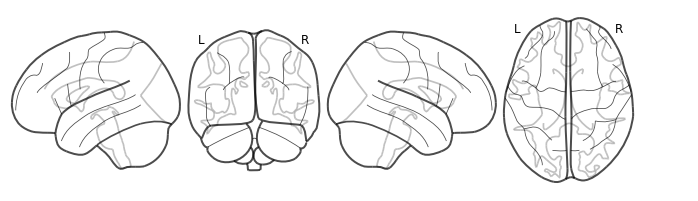

In [9]:
# Run mean analysis without covariates
call_mod1 = sdm_bin + " mod1=mi " + str(n_imps) + ",,," + str(n_threads)
run(call_mod1, shell=True, cwd=sdm_cwd)

# Run mean analysis with covariates
str_covs = "age_mean_c+modality_pres+modality_resp+software"
call_mod2 = sdm_bin + " mod2=mi " + str(n_imps) + "," + str_covs + ",," + str(n_threads)
run(call_mod2, shell=True, cwd=sdm_cwd)

# Run linear model for the influence of age
str_lin = "age_mean_c+age_mean_c_2,0+1+1+0+0"
call_mod3 = (
    sdm_bin + " mod3=mi_lm " + str_lin + "," + str(n_imps) + ",," + str(n_threads)
)
run(call_mod3, shell=True, cwd=sdm_cwd)

In [ ]:
# Family-wise error (FWE) correction for all models
_ = [
    run(
        sdm_bin + " perm " + mod + "," + str(n_perms) + "," + str(n_threads),
        shell=True,
        cwd=sdm_cwd,
    )
    for mod in ["mod1", "mod2", "mod3"]
]

In [ ]:
# Thresholding for all model (voxel-corrected)
_ = [
    run(
        sdm_bin
        + " threshold analysis_"
        + mod
        + "/corrp_voxel, analysis_"
        + mod
        + "/"
        + mod
        + "_z,"
        + str(thresh_voxel_p)
        + ","
        + str(thresh_cluster_k),
        shell=True,
        cwd=sdm_cwd,
    )
    for mod in ["mod1", "mod2", "mod3"]
]

In [ ]:
# Thresholding for all model (cluster-corrected)
_ = [
    run(
        sdm_bin
        + " threshold analysis_"
        + mod
        + "/corrp_tfce, analysis_"
        + mod
        + "/"
        + mod
        + "_z,"
        + str(thresh_voxel_p)
        + ","
        + str(thresh_cluster_k),
        shell=True,
        cwd=sdm_cwd,
    )
    for mod in ["mod1", "mod2", "mod3"]
]

In [ ]:
# Collect the filenames of the maps created in the previous step
fnames_maps = glob("../results/sdm/analysis_mod*/mod*_z_voxelCorrected*0.nii.gz")

# Apply cluster-level threshold to these maps (SDM only does this for the HTML file)
imgs = [
    dual_thresholding(
        stat_img=fname,
        voxel_thresh=0.001,
        cluster_size=200,
        fname_out=sub("_voxelCorrected.*0.nii.gz", "_thresh.nii.gz", fname),
    )
    for fname in fnames_maps
]

In [ ]:
# Glass brain example
p = plotting.plot_glass_brain(imgs[0], display_mode="lyrz", colorbar=True)

# Cluster table example
t = reporting.get_clusters_table(imgs[0], stat_threshold=0, min_distance=1000)
t.style.format(
    {"X": "{:.0f}", "Y": "{:.0f}", "Z": "{:.0f}", "Peak Stat": "{:.2f}"}
).hide_index()